# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score,precision_score , roc_auc_score, make_scorer
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 6.8 MB 23.6 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 60.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 316 kB 4.0 MB/s 
     |████████████████████████████████| 233 kB 39.1 MB/s 
     |████████████████████████████████| 1.4 MB 39.3 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=9c34aa5c52d1e2ac0385eb363d1fb4a594496e45995253df503cb39621675dbe
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154469 sha256=af133a40a74661ad1c4e801555fd0048abf

# step1

# Loading & Preprocessing data

In [2]:
#removed 

Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 97.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 4.56MB/s]


In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]
    self.source_name = data['source_name']
    self.keywords = data['keywords']
# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

for run section bias against journal name use this section 

In [5]:
# # a class to hold our data structure
# class Data:
#   def __init__(self, data, preprocessing=False):
#     self.title = data['title']
#     self.text = re.sub(data['source_name'], '', str(data['text']))
#     self.category = data['category']
#     self.label = label_encoder.transform([data['tag']])[0]
#     self.source_name = data['source_name']
#     self.keywords = data['keywords']
# # label encoder
# all_labels = ['مهم','غیر مهم']
# label_encoder.fit(all_labels)
# classes = label_encoder.classes_

# # convert raw data into Data objects
# news_data = []
# for index, data in news.iterrows():
#   news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.8,0.0,.2]):
  random.shuffle(data)
  data_len = len(data)
  print(data_len)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:27<00:00, 45.63it/s]

3785


In [9]:
# train data
title = []
text = []
category = []
label = []
source_name = []
keywords = []

for i in range(len(train_data)):
    title.append(train_data[i].title)
    text.append(train_data[i].text)
    category.append(train_data[i].category)
    label.append(train_data[i].label)
    source_name.append(train_data[i].source_name)
    keywords.append(train_data[i].keywords)
zippedList =  list(zip(title, text, category, keywords, source_name, label))
# Create a dataframe from zipped list
train = pd.DataFrame(zippedList, columns = ['title' , 'text', 'category', 'keywords', 'source_name','label'])
print(train.shape)
train.head(5)

(3028, 6)


,title,text,category,keywords,source_name,label
0,ابتلای امام جمعه استان یزد به کرونا,گزارش خبرنگار خبرگزاری یزد آیت الله محمدرضا ن...,مذهبی,NaN,شبستان,0
1,خواب آرام و با کیفیت را با این مکمل ها تجربه کنید,ملاتونین ملاتونین شناخته ترین مکمل های خواب نم...,علمی و پزشکی,"خواب,عناب,خواب راحت,منیزیم,پارسی خبر,",پارسینه,0
2,سقوط آزاد سرمایه گذاری در صنعت برق اردبیل,بازار گروه استان ها سرمایه صنعت برق ضرورت ها ا...,اقتصادی,"صنعت برق,سرمایه گذاری,قطعی برق,",تحلیل بازار,0
3,اندیشکده روسی|کرملین و ناکارآمدی نهادهای غربی,گزارش گروه الملل اختلافات مسکو غرب کارشناسان ...,بین الملل,NaN,خبرگزاری تسنیم,0
4,اعلام حالت فوق‌العاده یک ماهه در فلسطین برای م...,گزارشبه نقل خبرگزاری فلسطینی وفا محمود عباس ر...,بین الملل,NaN,باشگاه خبرنگاران,0


In [10]:
# validation data
title = []
text = []
category = []
label = []
source_name = []
keywords = []

for i in range(len(eval_data)):
    title.append(eval_data[i].title)
    text.append(eval_data[i].text)
    category.append(eval_data[i].category)
    label.append(eval_data[i].label)
    source_name.append(eval_data[i].source_name)
    keywords.append(eval_data[i].keywords)
zippedList =  list(zip(title, text, category, keywords, source_name, label))
# Create a dataframe from zipped list
val = pd.DataFrame(zippedList, columns = ['title' , 'text', 'category', 'keywords', 'source_name','label'])
print(val.shape)
val.head(5)

(0, 6)


,title,text,category,keywords,source_name,label


In [11]:
# test data
title = []
text = []
category = []
label = []
source_name = []
keywords = []

for i in range(len(test_data)):
    title.append(test_data[i].title)
    text.append(test_data[i].text)
    category.append(test_data[i].category)
    label.append(test_data[i].label)
    source_name.append(test_data[i].source_name)
    keywords.append(test_data[i].keywords)
zippedList =  list(zip(title, text, category, keywords, source_name, label))
# Create a dataframe from zipped list
test = pd.DataFrame(zippedList, columns = ['title' , 'text', 'category', 'keywords', 'source_name','label'])
print(test.shape)
test.head(5)

(757, 6)


,title,text,category,keywords,source_name,label
0,سازمان محیط زیست از پرداخت سود واردات تجهیزات ...,گزارش نقل پایگاه اطلاع رسانی دفتر هیئت دولت ه...,اجتماعی,"پایگاه اطلاع رسانی دفتر هیئت دولت,معافیت مالیا...",خبرگزاری مهر,0
1,نخبه پروری در خزانه تهران ادامه دارد/ کرونا مت...,گزارش آغاز فعالیت مرکز نخبه پروری مسجد خزانه ...,اجتماعی,"مسجد خزانه تهران,مسجد شهید بخارایی خزانه,حجت ا...",ایکنا,0
2,اجرای برنامه های فرهنگی کانون پرورش فکری قم در...,گزارش روابط عمومی اداره کانون پرورش فکری کودک...,ورزشی,NaN,کانون پرورش فکری کودکان ونوجوانان,0
3,السیلیه با رضاییان جام می خواهد,گزارش ورزش مسابقه فینال فصل جام اتحاد فدراسیو...,ورزشی,"قطر,السیلیه,رامین رضاییان,",ورزش 3,0
4,مداحی جانسوز حاج مجتبی رمضانی؛ ازمون گرفتن اون...,گزارش کرمان امسال شیوع ویروس کرونا پیاده اربع...,مذهبی,NaN,خبرگزاری تسنیم,0


# vectorization

In [12]:
# tf-idf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(data, ngrams=(1, 2)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    vectors = tfidf_vectorizer.fit_transform(data)

    return vectors, tfidf_vectorizer

# bow vectorization
from sklearn.feature_extraction.text import CountVectorizer
def bow(data, ngrams=(1, 2)):
    bow_vectorizer = CountVectorizer(ngram_range=ngrams)
    vectors = bow_vectorizer.fit_transform(data)

    return vectors, bow_vectorizer

In [13]:
train_tfidf, tfidf_vectorizer = tfidf(train["text"])
# val_tfidf = tfidf_vectorizer.transform(val["text"])
test_tfidf = tfidf_vectorizer.transform(test["text"])

In [14]:
train_bow, bow_vectorizer = bow(train["text"])
# val_bow = bow_vectorizer.transform(val["text"])
test_bow = bow_vectorizer.transform(test["text"])

In [15]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["label"].values

# X_val_tfidf = val_tfidf
# y_val_tfidf = val["label"].values

X_test_tfidf = test_tfidf
y_test_tfidf = test["label"].values

In [16]:
X_train_bow = train_bow
y_train_bow = train["label"].values

# X_val_bow = val_bow
# y_val_bow = val["label"].values

X_test_bow = test_bow
y_test_bow = test["label"].values

# define evaluation metrics

In [17]:
# a function to print evaluation using given predicted labels and real labels
import seaborn as sns
def print_evaluation(real, pred):
    f1macro = f1_score(real, pred, average= 'macro')
    f1micro = f1_score(real, pred, average='micro')
    acc = accuracy_score(real, pred)
    recall = recall_score(real, pred, average= 'macro', zero_division=0) #zero_division=1
    precision = precision_score(real, pred, average= 'macro') #,zero_division=1
    rocauc = roc_auc_score(real, pred)
    confmat = confusion_matrix(real, pred)
    print(f'f1-score macro: {f1macro}')
    print(f'f1-score micro: {f1micro}')
    print(f'accuracy score: {acc}')
    print(f'recall score: {recall}')
    print(f'precision score: {precision}')
    print(f'ROCAUC score: {rocauc}')
    fig, ax = plt.subplots()
    sns.heatmap(confmat, xticklabels=['not importnt','important'] , yticklabels=['not importnt','important'], annot=True, cmap='hot')
    ax.set_xlabel( "Predicted label")
    ax.set_ylabel( "True label")
    ax.set_title( "Confusion Matrix") 

# step3 & step4

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## tf-idf

In [ ]:
# logistic regression model tuning
lrm_param_grid = {'C': [0.01, 0.1, 1, 10],
                  'class_weight':[{0:0.15, 1:1},{0:0.3, 1:1},{0:0.2, 1:3},{0:0.15, 1:5}],
                  'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']} 
lrm_grid = GridSearchCV(LogisticRegression(),
                        lrm_param_grid,
                        refit=True,
                        verbose=3,
                        scoring='f1_macro')

In [ ]:
lrm_grid.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.119 total time=   1.0s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.119 total time=   1.0s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.119 total time=   1.0s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.118 total time=   1.0s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.119 total time=   1.0s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.119 total time=   0.8s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.119 total time=   0.7s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.119 total time=   0.7s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.118 total time=   0.7s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.119 total time=   4.9s
[CV 2/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.119 total time=   4.3s
[CV 3/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.119 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.118 total time=   4.9s
[CV 5/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.119 total time=   4.8s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.119 total time=   0.9s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.119 total time=   0.9s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.119 total time=   0.9s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.118 total time=   1.0s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.119 total time=   1.0s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.119 total time=   1.0s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.119 total time=   1.1s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.119 total time=   1.1s
[CV 4/5] END C

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.118 total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   5.0s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.531 total time=   0.6s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.530 total time=   0.6s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.512 total time=   0.6s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.493 total time=   0.6s
[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.522 total time=   0.5s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.531 total time=   0.9s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.530 total time=   0.9s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.512 total time=   0.8s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.493 total time=   1.2s
[CV 5/5] END C=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   3.6s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.118 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.119 total time=   3.8s
[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.606 total time=   1.2s
[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.653 total time=   1.3s
[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.632 total time=   1.2s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.694 total time=   1.2s
[CV 5/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.649 total time=   1.1s
[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.606 total time=   1.2s
[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.653 total time=   1.2s
[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.632 total time=   1.2s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.694 total time=   1.3s
[CV 5/5] END C=1, class_weight={0: 0.15

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.482 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.523 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.507 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.498 total time=   3.6s
[CV 5/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.533 total time=   2.9s
[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.374 total time=   1.9s
[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.383 total time=   1.9s
[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.359 total time=   1.9s
[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.325 total time=   1.9s
[CV 5/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.358 total time=   2.0s
[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.374 total time=   4.6s
[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.383 total time=   4.7s
[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.359 total time=   4.3s
[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solve

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.125 total time=   3.2s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.122 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.138 total time=   3.5s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.596 total time=   1.6s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.622 total time=   1.7s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.611 total time=   1.7s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.683 total time=   1.7s
[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.592 total time=   1.7s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.596 total time=   5.5s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.622 total time=   3.0s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.611 total time=   4.2s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.683 total time=   4.4s
[CV 5/5] END C=10, class_weight=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.596 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.621 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.617 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.683 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.575 total time=   4.3s
[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.509 total time=   2.0s
[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.584 total time=   2.0s
[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.604 total time=   2.0s
[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.623 total time=   2.0s
[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.549 total time=   2.0s
[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.509 total time=   8.6s
[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.584 total time=   7.1s
[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.604 total time=   7.1s
[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.623 total time=   8.2s
[CV 5/5] END C=10, class_weight={0: 0.3,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.509 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.573 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.604 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.623 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.549 total time=   3.6s
[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.622 total time=   2.2s
[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.641 total time=   1.8s
[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.635 total time=   1.9s
[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.688 total time=   2.1s
[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.640 total time=   2.0s
[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.622 total time=   9.3s
[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.641 total time=  10.3s
[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.635 total time=   9.5s
[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.688 total time=  13.6s
[CV 5/5] END C=10, class_weight={0: 0.2, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.627 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.641 total time=   3.4s
[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.636 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.686 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.638 total time=   3.5s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.607 total time=   1.9s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.622 total time=   1.9s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.630 total time=   1.9s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.630 total time=   2.0s
[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.650 total time=   1.8s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.607 total time=   9.1s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.622 total time=   7.0s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.630 total time=   9.4s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.630 total time=   8.3s
[CV 5/5] END C=10, class_weight=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.622 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.626 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.629 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.647 total time=   3.5s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='f1_macro', verbose=3)

In [ ]:
# best parameter for model
lrm_grid.best_params_

{'C': 1, 'class_weight': {0: 0.15, 1: 1}, 'solver': 'newton-cg'}

f1-score macro: 0.6494691046929852
f1-score micro: 0.7727873183619551
accuracy score: 0.7727873183619551
recall score: 0.7043466223698782
precision score: 0.6342537014805922
ROCAUC score: 0.7043466223698782


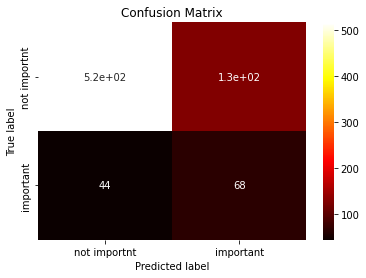

In [ ]:
model_tfidf = LogisticRegression(C=1, class_weight={0: 0.15, 1: 1}, solver='newton-cg')
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, y_pred_tfidf)

In [ ]:
# a = model_tfidf.predict_proba(X_test_tfidf)
# print(a[:6])

In [ ]:
import pickle
# save
with open("LR_model.pkl", "wb") as f:
    pickle.dump(model_tfidf, f)

In [ ]:
# link to saved nodel 


Downloading...
From: https://drive.google.com/uc?id=1-Cmz7zYxmAc3MOVWHMpkaQgF_lWTGNrD
To: /content/LR_model.pkl
100% 4.34M/4.34M [00:00<00:00, 130MB/s]


In [ ]:
# load
with open("LR_model.pkl", "rb") as f:
    model_tfidf = pickle.load(f)

## bow

In [ ]:
lrm_grid.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.631 total time=   4.5s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.637 total time=   4.8s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.633 total time=   3.9s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.636 total time=   4.4s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.640 total time=   4.8s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.631 total time=   9.3s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.637 total time=   7.6s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.633 total time=   8.7s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.636 total time=  12.1s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.591 total time=   6.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.638 total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.642 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.631 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.616 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.568 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.611 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.635 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.637 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.613 total time=   3.7s
[CV 1/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.535 total time=   4.7s
[CV 2/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.587 total time=   5.7s
[CV 3/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.628 total time=   3.9s
[CV 4/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.624 total time=   7.6s
[CV 5/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.592 total time=   8.8s
[CV 1/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.535 total time=   7.1s
[CV 2/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.587 total time=   7.6s
[CV 3/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.628 total time=   5.6s
[CV 4/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.624 total time=   7.6s
[CV 5/5] END C=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.579 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.619 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.632 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.626 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.595 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.572 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.631 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.625 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.632 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.606 total time=   3.7s
[CV 1/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.611 total time=   4.8s
[CV 2/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.608 total time=   5.2s
[CV 3/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.586 total time=   4.0s
[CV 4/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.587 total time=   4.8s
[CV 5/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.584 total time=   4.2s
[CV 1/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.610 total time=   7.5s
[CV 2/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.608 total time=   6.8s
[CV 3/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.586 total time=   6.0s
[CV 4/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.587 total time=   7.9s
[CV 5/5] END C=0.01, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.532 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.533 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.576 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.523 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.515 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.485 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.496 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.547 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.473 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.469 total time=   3.7s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.523 total time=   5.3s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.496 total time=   5.4s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.491 total time=   4.2s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.486 total time=   5.4s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.464 total time=   5.0s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.523 total time=   7.8s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.496 total time=   8.2s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.491 total time=   6.1s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.486 total time=   8.6s
[CV 5/5] END

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.430 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.433 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.514 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.400 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.419 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.349 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.366 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.493 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.318 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.357 total time=   3.9s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.591 total time=   4.9s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.621 total time=   4.6s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.636 total time=   4.2s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.645 total time=   5.3s
[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.601 total time=   5.9s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.591 total time=  10.5s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.621 total time=   9.1s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.636 total time=   7.9s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.645 total time=  10.1s
[CV 5/5] END C=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.580 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.641 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.650 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.634 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.615 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.568 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.614 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.648 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.639 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.611 total time=   4.0s
[CV 1/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.538 total time=   6.2s
[CV 2/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.612 total time=   5.1s
[CV 3/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.630 total time=   4.8s
[CV 4/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.626 total time=   5.7s
[CV 5/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.595 total time=   5.5s
[CV 1/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.538 total time=  11.0s
[CV 2/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.612 total time=   9.6s
[CV 3/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.630 total time=   9.0s
[CV 4/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.626 total time=  10.9s
[CV 5/5] END C=0.1, class_weig

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.584 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.637 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.637 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.630 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.595 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.572 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.631 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.633 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.627 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.606 total time=   3.7s
[CV 1/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.620 total time=   5.8s
[CV 2/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.630 total time=   5.6s
[CV 3/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.641 total time=   4.6s
[CV 4/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.647 total time=   5.6s
[CV 5/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.612 total time=   5.5s
[CV 1/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.620 total time=  11.3s
[CV 2/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.630 total time=  11.0s
[CV 3/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.641 total time=  10.2s
[CV 4/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.647 total time=  12.3s
[CV 5/5] END C=0.1, class_weigh

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.542 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.535 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.614 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.534 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.518 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.489 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.501 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.563 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.475 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.477 total time=   3.9s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.622 total time=   5.9s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.627 total time=   5.7s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.626 total time=   5.2s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.620 total time=   5.6s
[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.605 total time=   6.0s
[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.622 total time=  13.3s
[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.627 total time=  12.6s
[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.626 total time=   9.8s
[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.620 total time=  12.6s
[CV 5/5] END C=0.1, cl

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.449 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.437 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.547 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.416 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.429 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.358 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.379 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.519 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.330 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=0.1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.365 total time=   4.1s
[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.581 total time=   6.0s
[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.638 total time=   5.6s
[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.620 total time=   4.5s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.619 total time=   4.9s
[CV 5/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.585 total time=   5.6s
[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.581 total time=  11.8s
[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.638 total time=  12.3s
[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.620 total time=  11.2s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.619 total time=  12.3s
[CV 5/5] END C=1, class_weight={0: 0.15

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.585 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.640 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.658 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.634 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.616 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.567 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.614 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.648 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.641 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.611 total time=   3.9s
[CV 1/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.553 total time=   5.4s
[CV 2/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.617 total time=   6.0s
[CV 3/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.611 total time=   4.9s
[CV 4/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.626 total time=   5.4s
[CV 5/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.587 total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.553 total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.617 total time=  13.5s
[CV 3/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.611 total time=  12.0s
[CV 4/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.626 total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.587 total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.586 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.631 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.635 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.632 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.595 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.572 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.631 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.633 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.627 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.606 total time=   6.6s
[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.600 total time=  14.3s
[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.621 total time=   7.7s
[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.617 total time=   5.2s
[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.631 total time=   6.2s
[CV 5/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.609 total time=   5.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.600 total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.621 total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.617 total time=  14.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.631 total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.609 total time=  12.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.542 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.538 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.617 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.537 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.519 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.490 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.502 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.567 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.475 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.479 total time=   3.8s
[CV 1/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.603 total time=   6.4s
[CV 2/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.624 total time=   5.9s
[CV 3/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.648 total time=   6.0s
[CV 4/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.654 total time=   6.6s
[CV 5/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.623 total time=   7.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.603 total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.624 total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.648 total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.654 total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.623 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.450 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.438 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.548 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.414 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.433 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.362 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.380 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.517 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.332 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=1, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.368 total time=   3.9s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.584 total time=   6.9s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.624 total time=   7.4s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.609 total time=   5.6s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.624 total time=   6.2s
[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=newton-cg;, score=0.581 total time=   6.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.584 total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.624 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.609 total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.624 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=lbfgs;, score=0.581 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.577 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.640 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.658 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.632 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=sag;, score=0.616 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.565 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.616 total time=   4.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.648 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.640 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 1}, solver=saga;, score=0.612 total time=   4.2s
[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.573 total time=   6.4s
[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.619 total time=   6.4s
[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.604 total time=   6.4s
[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.623 total time=   5.9s
[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=newton-cg;, score=0.590 total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.573 total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.619 total time=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.604 total time=  14.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.623 total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=lbfgs;, score=0.590 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.586 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.631 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.635 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.630 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=sag;, score=0.595 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.571 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.631 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.631 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.627 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.3, 1: 1}, solver=saga;, score=0.606 total time=   3.7s
[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.583 total time=   7.2s
[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.636 total time=   6.7s
[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.600 total time=   6.0s
[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.617 total time=   7.3s
[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=newton-cg;, score=0.591 total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.583 total time=  13.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.636 total time=  13.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.600 total time=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.617 total time=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=lbfgs;, score=0.591 total time=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.542 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.538 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.621 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.537 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=sag;, score=0.519 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.491 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.502 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.568 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.475 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.2, 1: 3}, solver=saga;, score=0.477 total time=   3.7s
[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.582 total time=   8.0s
[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.629 total time=   6.9s
[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.623 total time=   6.7s
[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.649 total time=   7.1s
[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=newton-cg;, score=0.614 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.576 total time=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.629 total time=  13.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.623 total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.649 total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=lbfgs;, score=0.614 total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.449 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.437 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.549 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.421 total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=sag;, score=0.431 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 1/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.361 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 2/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.379 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 3/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.517 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 4/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.329 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV 5/5] END C=10, class_weight={0: 0.15, 1: 5}, solver=saga;, score=0.368 total time=   3.7s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'C': 0.01, 'class_weight': {0: 0.15, 1: 1}, 'solver': 'newton-cg'}

f1-score macro: 0.6536365083154293
f1-score micro: 0.8177014531043593
accuracy score: 0.8177014531043593
recall score: 0.6606104651162791
precision score: 0.6478176119859349
ROCAUC score: 0.6606104651162791


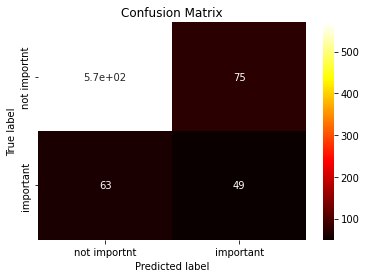

In [ ]:
model_bow = LogisticRegression(C=0.01, class_weight={0:0.15, 1:1}, solver='newton-cg')
model_bow.fit(X_train_bow, y_train_bow)
y_pred_bow = model_bow.predict(X_test_bow)
print_evaluation(y_test_bow, y_pred_bow)

# Naive Bayes

In [ ]:
from sklearn import naive_bayes

In [ ]:
# logistic regression model tuning
lrm_param_grid = {'alpha': [0.01, 0.1, 1, 10]} 
lrm_grid = GridSearchCV(naive_bayes.MultinomialNB(),
                        lrm_param_grid,
                        refit=True,
                        verbose=3,
                        scoring='f1_macro')

## tfidf

In [ ]:
lrm_grid.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................alpha=0.01;, score=0.449 total time=   0.1s
[CV 2/5] END ........................alpha=0.01;, score=0.459 total time=   0.1s
[CV 3/5] END ........................alpha=0.01;, score=0.450 total time=   0.1s
[CV 4/5] END ........................alpha=0.01;, score=0.437 total time=   0.1s
[CV 5/5] END ........................alpha=0.01;, score=0.481 total time=   0.1s
[CV 1/5] END .........................alpha=0.1;, score=0.463 total time=   0.1s
[CV 2/5] END .........................alpha=0.1;, score=0.463 total time=   0.1s
[CV 3/5] END .........................alpha=0.1;, score=0.463 total time=   0.1s
[CV 4/5] END .........................alpha=0.1;, score=0.464 total time=   0.1s
[CV 5/5] END .........................alpha=0.1;, score=0.464 total time=   0.1s
[CV 1/5] END ...........................alpha=1;, score=0.464 total time=   0.0s
[CV 2/5] END ...........................alpha=1;,

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, scoring='f1_macro',
             verbose=3)

In [ ]:
lrm_grid.best_params_

{'alpha': 1}

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1-score macro: 0.4577363896848137
f1-score micro: 0.8441215323645971
accuracy score: 0.8441215323645971
recall score: 0.5
precision score: 0.42206076618229854
ROCAUC score: 0.5


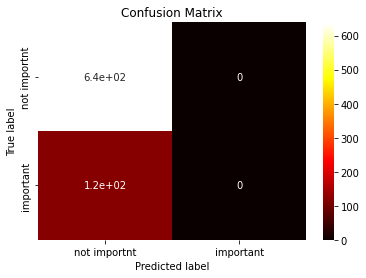

In [ ]:
Naive_tfidf = naive_bayes.MultinomialNB(alpha=1)
Naive_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_NB_tfidf = Naive_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_NB_tfidf)

In [ ]:
import pickle
# save
with open("NB_model.pkl", "wb") as f:
    pickle.dump(Naive_tfidf, f)

In [ ]:
# link to saved nodel 


Downloading...
From: https://drive.google.com/uc?id=1-DwxuYRH0eLsim-yomD0S1oXCbWMzym6
To: /content/NB_model.pkl
100% 17.4M/17.4M [00:00<00:00, 234MB/s]


In [ ]:
# load
with open("NB_model.pkl", "rb") as f:
    Naive_tfidf = pickle.load(f)

## bow

In [ ]:
lrm_grid.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................alpha=0.01;, score=0.529 total time=   0.1s
[CV 2/5] END ........................alpha=0.01;, score=0.501 total time=   0.1s
[CV 3/5] END ........................alpha=0.01;, score=0.491 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.474 total time=   0.1s
[CV 5/5] END ........................alpha=0.01;, score=0.511 total time=   0.0s
[CV 1/5] END .........................alpha=0.1;, score=0.435 total time=   0.1s
[CV 2/5] END .........................alpha=0.1;, score=0.421 total time=   0.1s
[CV 3/5] END .........................alpha=0.1;, score=0.393 total time=   0.1s
[CV 4/5] END .........................alpha=0.1;, score=0.399 total time=   0.1s
[CV 5/5] END .........................alpha=0.1;, score=0.417 total time=   0.1s
[CV 1/5] END ...........................alpha=1;, score=0.544 total time=   0.0s
[CV 2/5] END ...........................alpha=1;,

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, scoring='f1_macro',
             verbose=3)

In [ ]:
lrm_grid.best_params_

{'alpha': 1}

f1-score macro: 0.5036909329318634
f1-score micro: 0.857331571994716
accuracy score: 0.857331571994716
recall score: 0.521546234772979
precision score: 0.8454283177984909
ROCAUC score: 0.521546234772979


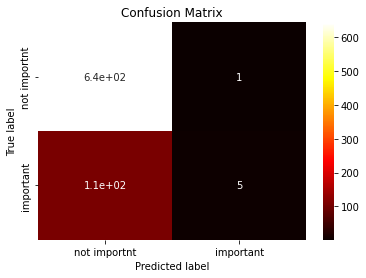

In [ ]:
Naive_bow = naive_bayes.MultinomialNB(alpha=1)
Naive_bow.fit(X_train_bow, y_train_bow)
predictions_NB_bow = Naive_bow.predict(X_test_bow)
print_evaluation(y_test_bow, predictions_NB_bow)

# SVM

In [ ]:
from sklearn import svm

In [ ]:
lrm_param_grid = {'C': [0.01, 0.1, 1, 10],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree': [2,3],
                  'class_weight':[{0:0.15, 1:1},{0:0.3, 1:1},{0:0.2, 1:3},{0:0.15, 1:5}]} 
lrm_grid = GridSearchCV(svm.SVC(),
                        lrm_param_grid,
                        refit=True,
                        verbose=3,
                        scoring='f1_macro')

## tfidf

In [ ]:
lrm_grid.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.119 total time=  18.4s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.119 total time=  20.4s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.119 total time=  22.3s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.118 total time=  19.7s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.119 total time=  17.3s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.119 total time=  16.9s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.119 total time=  16.8s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.119 total time=  16.9s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, scor

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'C': 1, 'class_weight': {0: 0.2, 1: 3}, 'degree': 2, 'kernel': 'linear'}

f1-score macro: 0.6532918601939346
f1-score micro: 0.7846763540290621
accuracy score: 0.7846763540290621
recall score: 0.6858969258109864
precision score: 0.6387382215535672
ROCAUC score: 0.6858969258109864


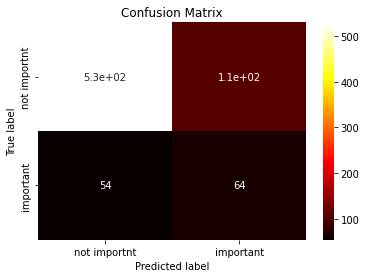

In [ ]:
svm_tfidf = svm.SVC(C=1, class_weight={0:0.2, 1:3}, degree=2, kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_svm_tfidf)

In [ ]:
import pickle
# save
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_tfidf, f)

In [ ]:
# link to saved nodel 


Downloading...
From: https://drive.google.com/uc?id=1-JpkW2Y4uHvtEk3a32R9hQBwmioL7NsI
To: /content/svm_model.pkl
100% 12.5M/12.5M [00:00<00:00, 76.6MB/s]


In [ ]:
# load
with open("svm_modelodel.pkl", "rb") as f:
    svm_tfidf = pickle.load(f)

## bow

In [ ]:
lrm_grid.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.553 total time=   8.9s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.631 total time=   8.8s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.625 total time=   8.9s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.649 total time=  11.3s
[CV 5/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=linear;, score=0.587 total time=  12.1s
[CV 1/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.119 total time=  18.8s
[CV 2/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.119 total time=  16.9s
[CV 3/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, score=0.118 total time=  14.8s
[CV 4/5] END C=0.01, class_weight={0: 0.15, 1: 1}, degree=2, kernel=poly;, scor

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'degree': [2, 3],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'C': 0.01, 'class_weight': {0: 0.15, 1: 5}, 'degree': 2, 'kernel': 'linear'}

f1-score macro: 0.643673677981602
f1-score micro: 0.8150594451783355
accuracy score: 0.8150594451783355
recall score: 0.6479928017718715
precision score: 0.6398613291470434
ROCAUC score: 0.6479928017718715


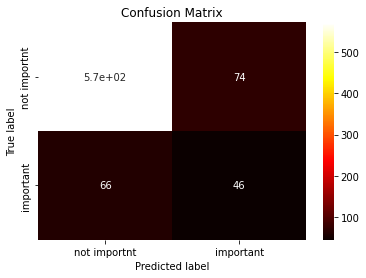

In [ ]:
svm_bow = svm.SVC(C=0.01, class_weight={0:0.15, 1:5}, degree=2, kernel='linear')
svm_bow.fit(X_train_bow, y_train_bow)
predictions_svm_bow = svm_bow.predict(X_test_bow)
print_evaluation(y_test_bow, predictions_svm_bow)

# DT

In [ ]:
from sklearn import tree
lrm_param_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1,2,3],
                  'class_weight':[{0:0.15, 1:1},{0:0.3, 1:1},{0:0.2, 1:3},{0:0.15, 1:5}]} 
lrm_grid = GridSearchCV(tree.DecisionTreeClassifier(),
                        lrm_param_grid,
                        refit=True,
                        verbose=3,
                        scoring='f1_macro')

## TF-IDF

In [ ]:
lrm_grid.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.324 total time=   1.2s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.289 total time=   1.2s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.325 total time=   1.2s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.325 total time=   1.2s
[CV 5/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.241 total time=   1.2s
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.236 total time=   1.2s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.189 total time=   1.1s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.192

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'splitter': ['best', 'random']},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'class_weight': {0: 0.3, 1: 1},
 'criterion': 'gini',
 'max_depth': 3,
 'splitter': 'random'}

f1-score macro: 0.49038160817178994
f1-score micro: 0.8322324966974901
accuracy score: 0.8322324966974901
recall score: 0.5102318240895467
precision score: 0.5550206817857652
ROCAUC score: 0.5102318240895467


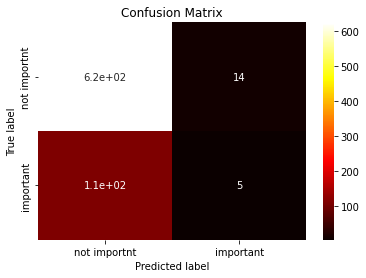

In [ ]:
dt_tfidf = tree.DecisionTreeClassifier(class_weight={0:0.3, 1:1}, criterion='gini', max_depth=3, splitter='random')
dt_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_dt_tfidf = dt_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_dt_tfidf)

In [ ]:
import pickle
# save
with open("DT_model.pkl", "wb") as f:
    pickle.dump(dt_tfidf, f)

In [ ]:
# link to saved nodel 


Downloading...
From: https://drive.google.com/uc?id=1-CZuYh3pUp-NvQq7lRQJrvZrDY5msm0v
To: /content/DT_model.pkl
100% 2.23k/2.23k [00:00<00:00, 2.58MB/s]


In [ ]:
# load
with open("DT_model.pkl", "rb") as f:
    dt_tfidf = pickle.load(f)

## BoW

In [ ]:
lrm_grid.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.331 total time=   1.2s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.337 total time=   1.2s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.327 total time=   1.1s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.329 total time=   1.2s
[CV 5/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=best;, score=0.241 total time=   1.2s
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.552 total time=   1.2s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.528 total time=   1.1s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1, splitter=random;, score=0.197

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'splitter': ['best', 'random']},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'class_weight': {0: 0.3, 1: 1},
 'criterion': 'gini',
 'max_depth': 3,
 'splitter': 'random'}

f1-score macro: 0.5537654621829237
f1-score micro: 0.8322324966974901
accuracy score: 0.8322324966974901
recall score: 0.5473975636766334
precision score: 0.6026071321546299
ROCAUC score: 0.5473975636766334


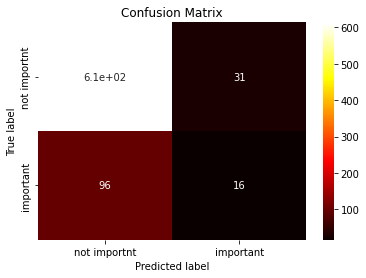

In [ ]:
dt_bow = tree.DecisionTreeClassifier(class_weight={0:0.3, 1:1}, criterion='gini', max_depth=3, splitter='random')
dt_bow.fit(X_train_bow, y_train_bow)
predictions_dt_bow = dt_bow.predict(X_test_bow)
print_evaluation(y_test_bow, predictions_dt_bow)

# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
lrm_param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [1,2,3],
                  'class_weight':[{0:0.15, 1:1},{0:0.3, 1:1},{0:0.2, 1:3},{0:0.15, 1:5}]} 
lrm_grid = GridSearchCV(RandomForestClassifier(),
                        lrm_param_grid,
                        refit=True,
                        verbose=3,
                        scoring='f1_macro')

## tfidf


In [ ]:
lrm_grid.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.296 total time=   1.4s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.323 total time=   0.9s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.328 total time=   2.2s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.241 total time=   1.7s
[CV 5/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.258 total time=   2.0s
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.475 total time=   2.3s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.461 total time=   2.1s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.435 total time=   1.4s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.506 total time=   1.3s
[C

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3]},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'class_weight': {0: 0.15, 1: 1}, 'criterion': 'gini', 'max_depth': 3}

f1-score macro: 0.5871784162824909
f1-score micro: 0.7291941875825627
accuracy score: 0.7291941875825627
recall score: 0.6184849208243813
precision score: 0.581522036682179
ROCAUC score: 0.6184849208243814


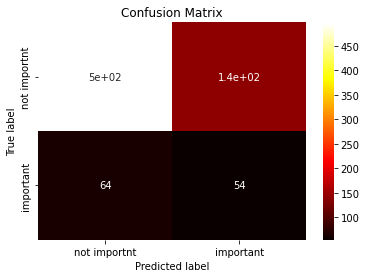

In [ ]:
rf_tfidf = RandomForestClassifier(class_weight={0:0.15, 1:1}, criterion='gini', max_depth=3) #
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_rf_tfidf)

In [ ]:
import pickle
# save
with open("RF_model.pkl", "wb") as f:
    pickle.dump(rf_tfidf, f)

In [ ]:
# link to saved nodel 


Downloading...
From: https://drive.google.com/uc?id=1-IZWsID3jaL3TTVZ7y_CEQxgC_v1cavH
To: /content/RF_model.pkl
100% 124k/124k [00:00<00:00, 18.0MB/s]


In [ ]:
# load
with open("RF_model.pkl", "rb") as f:
    rf_tfidf = pickle.load(f)

## bow

In [ ]:
lrm_grid.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.247 total time=   0.6s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.374 total time=   0.6s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.241 total time=   0.6s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.180 total time=   0.6s
[CV 5/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=1;, score=0.331 total time=   0.6s
[CV 1/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.494 total time=   0.7s
[CV 2/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.416 total time=   0.7s
[CV 3/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.449 total time=   0.7s
[CV 4/5] END class_weight={0: 0.15, 1: 1}, criterion=gini, max_depth=2;, score=0.514 total time=   0.7s
[C

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': [{0: 0.15, 1: 1}, {0: 0.3, 1: 1},
                                          {0: 0.2, 1: 3}, {0: 0.15, 1: 5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3]},
             scoring='f1_macro', verbose=3)

In [ ]:
lrm_grid.best_params_

{'class_weight': {0: 0.15, 1: 1}, 'criterion': 'gini', 'max_depth': 3}

f1-score macro: 0.5424323017408124
f1-score micro: 0.6036988110964333
accuracy score: 0.6036988110964333
recall score: 0.6862818383167221
precision score: 0.5940049737342126
ROCAUC score: 0.6862818383167221


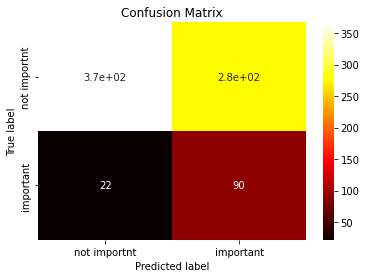

In [ ]:
rf_bow = RandomForestClassifier(class_weight={0:0.15, 1:1}, criterion='gini', max_depth=3)#
rf_bow.fit(X_train_bow, y_train_bow)
predictions_rf_bow = rf_bow.predict(X_test_bow)
print_evaluation(y_test_bow, predictions_rf_bow)

# 3 work on data

In [ ]:
train = train.fillna('')
train["titletext"] = train['title'] +' '+ train["text"]
train["cattext"] = train['category'] +' '+ train["text"]
train["keytext"] = train['keywords'] +' '+ train["text"]
train.head(3)

,title,text,category,keywords,source_name,label,titletext,cattext,keytext
0,روسیه از احتمال طولانی تر شدن این دور مذاکرات ...,گزارش مشرق میخائیل اولیانوف نماینده روسیه سازم...,سیاسی,"میخائیل اولیانوف,توافق هسته ای,کمیسیون مشترک,ب...",مشرق نیوز,0,روسیه از احتمال طولانی تر شدن این دور مذاکرات ...,سیاسی گزارش مشرق میخائیل اولیانوف نماینده روسی...,"میخائیل اولیانوف,توافق هسته ای,کمیسیون مشترک,ب..."
1,میراث شاهِ شهید,محمدعلی بهمنی پژوهشگر تاریخ سرویس تاریخ انتخاب...,فرهنگ و هنر,,انتخاب,0,میراث شاهِ شهید محمدعلی بهمنی پژوهشگر تاریخ سر...,فرهنگ و هنر محمدعلی بهمنی پژوهشگر تاریخ سرویس ...,محمدعلی بهمنی پژوهشگر تاریخ سرویس تاریخ انتخا...
2,صنعت نفت آبادان و مس رفسنجان به تساوی یک بر یک...,گزارش ایرنا دیدار شنبه شب ورزشگاه تختی آبادان ...,ورزشی,"فوتبال,خوزستان,لیگ برتر فوتبال,",ایرنا,0,صنعت نفت آبادان و مس رفسنجان به تساوی یک بر یک...,ورزشی گزارش ایرنا دیدار شنبه شب ورزشگاه تختی آ...,"فوتبال,خوزستان,لیگ برتر فوتبال, گزارش ایرنا دی..."


In [ ]:
test = test.fillna('')
test["titletext"] = test['title'] +' '+ test["text"]
test["cattext"] = test['category'] +' '+ test["text"]
test["keytext"] = test['keywords'] +' '+ test["text"]
test.head(3)

,title,text,category,keywords,source_name,label,titletext,cattext,keytext
0,بازداشت خانگی یکی از رهبران جنبش النهضه تونس,گزارش گروه ترجمه خبرگزاری حوزه رسانه های تونسی...,بین الملل,,حوزه,0,بازداشت خانگی یکی از رهبران جنبش النهضه تونس گ...,بین الملل گزارش گروه ترجمه خبرگزاری حوزه رسانه...,گزارش گروه ترجمه خبرگزاری حوزه رسانه های تونس...
1,سجادی: قیمت نان در گلستان نسبت به استان های هم...,سیدخالق سجادی امروز خبرنگار فارس گرگان اشاره پ...,اقتصادی,"قیمت نان,استان گلستان,ارزانتر,مطالبات,پرداخت,گ...",خبرگزاری فارس,0,سجادی: قیمت نان در گلستان نسبت به استان های هم...,اقتصادی سیدخالق سجادی امروز خبرنگار فارس گرگان...,"قیمت نان,استان گلستان,ارزانتر,مطالبات,پرداخت,گ..."
2,۴ نفر در سانحه تصادف جنوب کرمان جان باختند,برخورد سواری پراید کامیون سرنشین پراید دم جان ...,حوادث,"سانحه,تصادف,جنوب کرمان,",خبرگزاری تابناک,0,۴ نفر در سانحه تصادف جنوب کرمان جان باختند برخ...,حوادث برخورد سواری پراید کامیون سرنشین پراید د...,"سانحه,تصادف,جنوب کرمان, برخورد سواری پراید کام..."


In [ ]:
import pandas as pd
def dist(category, lable):
    d = {'category': ['بین الملل' ,'اقتصادی', 'حوادث', 'اجتماعی', 'مذهبی' ,'علمی و پزشکی', 'ورزشی',
        'فرهنگ و هنر', 'فناوری و ارتباطات', 'سیاسی'], 'all': [0,0,0,0,0,0,0,0,0,0], 'important':[0,0,0,0,0,0,0,0,0,0]}
    darsad = pd.DataFrame(data=d)
    label = pd.Series(lable)
    for i in range(len(category)):
        if category[i] == 'بین الملل':
            darsad['all'].iloc[0] += 1
            if label[i] == 1:
                darsad['important'].iloc[0] += 1
        elif category[i] == 'اقتصادی':
            darsad['all'].iloc[1] += 1
            if label[i] == 1:
                darsad['important'].iloc[1] += 1
        elif category[i] == 'حوادث':
            darsad['all'].iloc[2] += 1
            if label[i] == 1:
                darsad['important'].iloc[2] += 1
        elif category[i] == 'اجتماعی':
            darsad['all'].iloc[3] += 1
            if label[i] == 1:
                darsad['important'].iloc[3] += 1
        elif category[i] == 'مذهبی':
            darsad['all'].iloc[4] += 1
            if label[i] == 1:
                darsad['important'].iloc[4] += 1
        elif category[i] == 'علمی و پزشکی':
            darsad['all'].iloc[5] += 1
            if label[i] == 1:
                darsad['important'].iloc[5] += 1
        elif category[i] == 'ورزشی':
            darsad['all'].iloc[6] += 1
            if label[i] == 1:
                darsad['important'].iloc[6] += 1
        elif category[i] == 'فرهنگ و هنر':
            darsad['all'].iloc[7] += 1
            if label[i] == 1:
                darsad['important'].iloc[7] += 1
        elif category[i] == 'فناوری و ارتباطات':
            darsad['all'].iloc[8] += 1
            if label[i] == 1:
                darsad['important'].iloc[8] += 1
        elif category[i] == 'سیاسی':
            darsad['all'].iloc[9] += 1
            if label[i] == 1:
                darsad['important'].iloc[9] += 1
    darsad['percentage'] = 100*(darsad['important']/ darsad['important'].sum())
    return darsad

In [ ]:
data = dist(test['category'],test['label'])
data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,100,14,12.500000
1,اقتصادی,88,22,19.642857
2,حوادث,58,8,7.142857
3,اجتماعی,52,5,4.464286
4,مذهبی,56,0,0.000000
5,علمی و پزشکی,67,23,20.535714
6,ورزشی,121,18,16.071429
7,فرهنگ و هنر,82,2,1.785714
8,فناوری و ارتباطات,52,8,7.142857
9,سیاسی,81,12,10.714286


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

## text + title

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train["titletext"])
test_tfidf = tfidf_vectorizer.transform(test["titletext"])

In [ ]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["label"].values

X_test_tfidf = test_tfidf
y_test_tfidf = test["label"].values

f1-score macro: 0.6308600318364236
f1-score micro: 0.7701453104359313
accuracy score: 0.7701453104359313
recall score: 0.6662369376006112
precision score: 0.6182346548679436
ROCAUC score: 0.6662369376006112


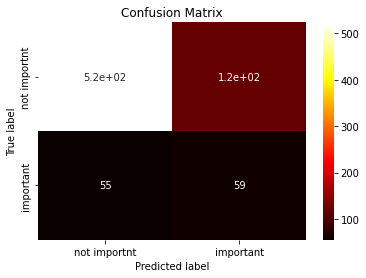

In [ ]:
model_tfidf = LogisticRegression(C=1, class_weight={0: 0.15, 1: 1}, solver='newton-cg')
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, y_pred_tfidf)

In [ ]:
dist(test['category'],y_pred_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,38,21.348315
1,اقتصادی,81,38,21.348315
2,حوادث,51,0,0.000000
3,اجتماعی,68,11,6.179775
4,مذهبی,58,1,0.561798
5,علمی و پزشکی,68,35,19.662921
6,ورزشی,118,27,15.168539
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,11,6.179775
9,سیاسی,74,17,9.550562


f1-score macro: 0.6295672031317965
f1-score micro: 0.76221928665786
accuracy score: 0.76221928665786
recall score: 0.6723963875474066
precision score: 0.6173025155481295
ROCAUC score: 0.6723963875474067


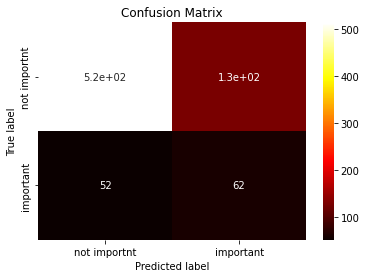

In [ ]:
svm_tfidf = svm.SVC(C=1, class_weight={0:0.2, 1:3}, degree=2, kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_svm_tfidf)

In [ ]:
dist(test['category'],predictions_svm_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,37,19.473684
1,اقتصادی,81,36,18.947368
2,حوادث,51,3,1.578947
3,اجتماعی,68,12,6.315789
4,مذهبی,58,1,0.526316
5,علمی و پزشکی,68,36,18.947368
6,ورزشی,118,28,14.736842
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,19,10.000000
9,سیاسی,74,18,9.473684


## text + category

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train["cattext"])
test_tfidf = tfidf_vectorizer.transform(test["cattext"])

In [ ]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["label"].values

X_test_tfidf = test_tfidf
y_test_tfidf = test["label"].values

f1-score macro: 0.6212386758461843
f1-score micro: 0.7635402906208718
accuracy score: 0.7635402906208718
recall score: 0.6551321928460342
precision score: 0.6099099186174635
ROCAUC score: 0.6551321928460341


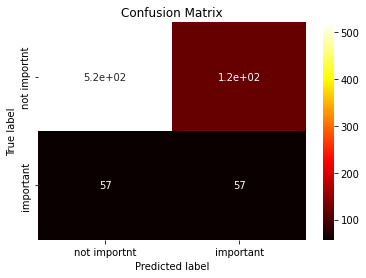

In [ ]:
model_tfidf = LogisticRegression(C=1, class_weight={0: 0.15, 1: 1}, solver='newton-cg')
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, y_pred_tfidf)

In [ ]:
dist(test['category'],y_pred_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,40,22.346369
1,اقتصادی,81,39,21.787709
2,حوادث,51,0,0.000000
3,اجتماعی,68,13,7.262570
4,مذهبی,58,1,0.558659
5,علمی و پزشکی,68,36,20.111732
6,ورزشی,118,25,13.966480
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,10,5.586592
9,سیاسی,74,15,8.379888


f1-score macro: 0.627006344880741
f1-score micro: 0.7635402906208718
accuracy score: 0.7635402906208718
recall score: 0.6659572726528608
precision score: 0.614959364959365
ROCAUC score: 0.6659572726528608


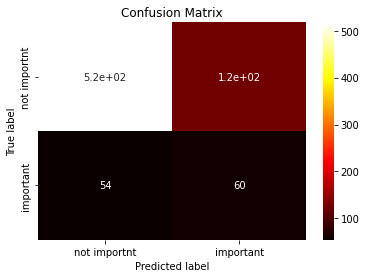

In [ ]:
svm_tfidf = svm.SVC(C=1, class_weight={0:0.2, 1:3}, degree=2, kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_svm_tfidf)

In [ ]:
dist(test['category'], predictions_svm_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,37,20.000000
1,اقتصادی,81,36,19.459459
2,حوادث,51,2,1.081081
3,اجتماعی,68,10,5.405405
4,مذهبی,58,1,0.540541
5,علمی و پزشکی,68,37,20.000000
6,ورزشی,118,28,15.135135
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,19,10.270270
9,سیاسی,74,15,8.108108


## text + keywords

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train["keytext"])
test_tfidf = tfidf_vectorizer.transform(test["keytext"])

In [ ]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["label"].values

X_test_tfidf = test_tfidf
y_test_tfidf = test["label"].values

f1-score macro: 0.6277673345640403
f1-score micro: 0.7688243064729194
accuracy score: 0.7688243064729194
recall score: 0.6618509726883305
precision score: 0.6155659458406391
ROCAUC score: 0.6618509726883305


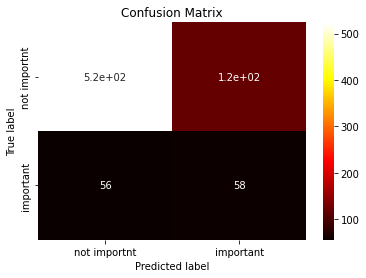

In [ ]:
model_tfidf = LogisticRegression(C=1, class_weight={0: 0.15, 1: 1}, solver='newton-cg')
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, y_pred_tfidf)

In [ ]:
dist(test['category'], y_pred_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,35,19.774011
1,اقتصادی,81,38,21.468927
2,حوادث,51,1,0.564972
3,اجتماعی,68,13,7.344633
4,مذهبی,58,1,0.564972
5,علمی و پزشکی,68,36,20.338983
6,ورزشی,118,26,14.689266
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,10,5.649718
9,سیاسی,74,17,9.604520


f1-score macro: 0.6288738007137517
f1-score micro: 0.7635402906208718
accuracy score: 0.7635402906208718
recall score: 0.6695656325884696
precision score: 0.6166103762078995
ROCAUC score: 0.6695656325884697


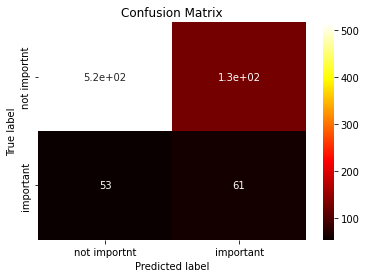

In [ ]:
svm_tfidf = svm.SVC(C=1, class_weight={0:0.2, 1:3}, degree=2, kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_svm_tfidf)

In [ ]:
dist(test['category'], predictions_svm_tfidf)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,category,all,important,percentage
0,بین الملل,117,37,19.786096
1,اقتصادی,81,35,18.716578
2,حوادث,51,2,1.069519
3,اجتماعی,68,11,5.882353
4,مذهبی,58,2,1.069519
5,علمی و پزشکی,68,35,18.716578
6,ورزشی,118,29,15.508021
7,فرهنگ و هنر,68,0,0.000000
8,فناوری و ارتباطات,54,19,10.160428
9,سیاسی,74,17,9.090909


# bias against journal name

In [ ]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = re.sub(data['source_name'], '', str(data['text']))
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]
    self.source_name = data['source_name']
    self.keywords = data['keywords']
# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [ ]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

In [ ]:
# train data
title = []
text = []
category = []
label = []
source_name = []
keywords = []

for i in range(len(train_data)):
    title.append(train_data[i].title)
    text.append(train_data[i].text)
    category.append(train_data[i].category)
    label.append(train_data[i].label)
    source_name.append(train_data[i].source_name)
    keywords.append(train_data[i].keywords)
zippedList =  list(zip(title, text, category, keywords, source_name, label))
# Create a dataframe from zipped list
train = pd.DataFrame(zippedList, columns = ['title' , 'text', 'category', 'keywords', 'source_name','label'])
print(train.shape)
train.head(5)

In [ ]:
# test data
title = []
text = []
category = []
label = []
source_name = []
keywords = []

for i in range(len(test_data)):
    title.append(test_data[i].title)
    text.append(test_data[i].text)
    category.append(test_data[i].category)
    label.append(test_data[i].label)
    source_name.append(test_data[i].source_name)
    keywords.append(test_data[i].keywords)
zippedList =  list(zip(title, text, category, keywords, source_name, label))
# Create a dataframe from zipped list
test = pd.DataFrame(zippedList, columns = ['title' , 'text', 'category', 'keywords', 'source_name','label'])
print(test.shape)
test.head(5)

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train["text"])
# val_tfidf = tfidf_vectorizer.transform(val["text"])
test_tfidf = tfidf_vectorizer.transform(test["text"])

In [ ]:
train_bow, bow_vectorizer = bow(train["text"])
# val_bow = bow_vectorizer.transform(val["text"])
test_bow = bow_vectorizer.transform(test["text"])

In [ ]:
X_train_tfidf = train_tfidf
y_train_tfidf = train["label"].values

# X_val_tfidf = val_tfidf
# y_val_tfidf = val["label"].values

X_test_tfidf = test_tfidf
y_test_tfidf = test["label"].values

In [ ]:
X_train_bow = train_bow
y_train_bow = train["label"].values

# X_val_bow = val_bow
# y_val_bow = val["label"].values

X_test_bow = test_bow
y_test_bow = test["label"].values

## LR model

f1-score macro: 0.646575756512634
f1-score micro: 0.7714663143989433
accuracy score: 0.7714663143989432
recall score: 0.6998823366555924
precision score: 0.6317592846062596
ROCAUC score: 0.6998823366555924


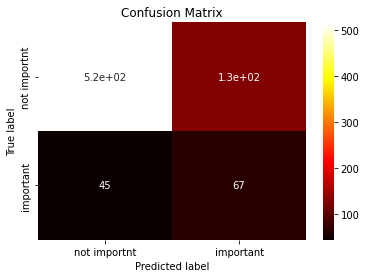

In [18]:
from sklearn.linear_model import LogisticRegression
model_tfidf = LogisticRegression(C=1, class_weight={0: 0.15, 1: 1}, solver='newton-cg')
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, y_pred_tfidf)

## svm model

f1-score macro: 0.647591330972858
f1-score micro: 0.7688243064729194
accuracy score: 0.7688243064729194
recall score: 0.7057101328903654
precision score: 0.6329727262965748
ROCAUC score: 0.7057101328903654


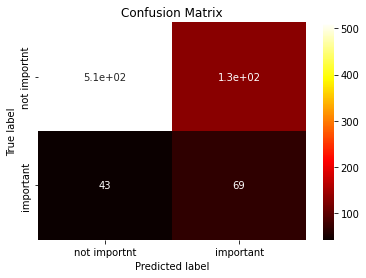

In [19]:
from sklearn import svm
svm_tfidf = svm.SVC(C=1, class_weight={0:0.2, 1:3}, degree=2, kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
predictions_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
print_evaluation(y_test_tfidf, predictions_svm_tfidf)